# Out-of-reference detection benchmark - Quick start example

In [25]:
import os
import numpy as np
from anndata import AnnData
import oor_benchmark
import scanpy as sc

import matplotlib.pyplot as plt

In [27]:
## Make temporary directory to store results
outdir = './tmp/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Load example data

In [2]:
adata = oor_benchmark.api.sample_dataset()
## Rename latent dimensions to X_scVI to avoid retraining models
adata.obsm['X_scVI'] = adata.obsm['X_pca'].copy()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'cell_annotation', 'sample_id', 'dataset_group'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_scVI'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Cells are split into atlas dataset, control dataset and query dataset.

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


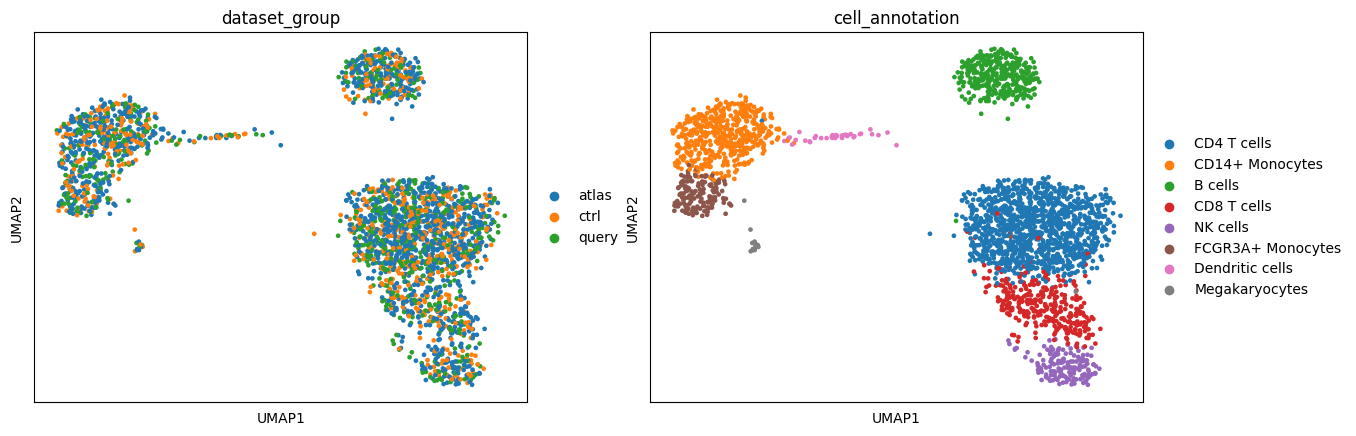

In [4]:
sc.pl.umap(adata, color=['dataset_group', 'cell_annotation'])

## Datasets - simulate out-of-reference state

In [6]:
from oor_benchmark.datasets import simulation
query_samples = adata.obs[adata.obs['dataset_group'] == 'query']['sample_id'].unique().tolist()
ctrl_samples = adata.obs[adata.obs['dataset_group'] == 'ctrl']['sample_id'].unique().tolist()
adata = simulation.simulate_query_reference(adata, 
    batch_col = 'sample_id', 
    query_batch=query_samples, 
    ctrl_batch=ctrl_samples, 
    query_annotation = ['B cells'],
    annotation_col='cell_annotation')


One of the cell clusters is now the out-of-reference (OOR) state, which is present only in the query dataset and excluded from atlas and control.

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


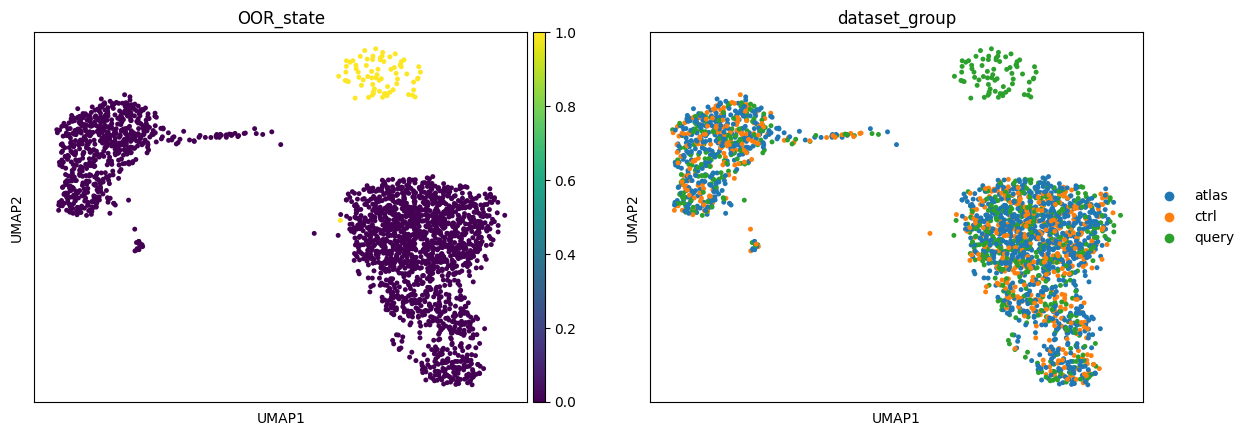

In [7]:
sc.pl.umap(adata, color=['OOR_state', 'dataset_group'])

## Methods - run OOR detection workflow

In [ ]:
from oor_benchmark.methods import scArches_milo
from oor_benchmark.methods import scArches_mappingQC

adata_milo = scArches_milo.scArches_atlas_milo_ctrl(adata, harmonize_output=True)
adata_label_uncertainty = scArches_mappingQC.scArches_atlas_mappingQClabels(adata, harmonize_output=True, outdir=outdir)

## Metrics - quantify performance

In [31]:
from oor_benchmark.metrics.FDR_TPR_FPR import FDR_TPR_FPR
from oor_benchmark.metrics.auprc import auprc 

FDR_TPR_FPR(adata_milo)

,TP,FP,FN,TN,TPR,FPR,FDR
0,3,0,0,31,1.0,0.0,0.0


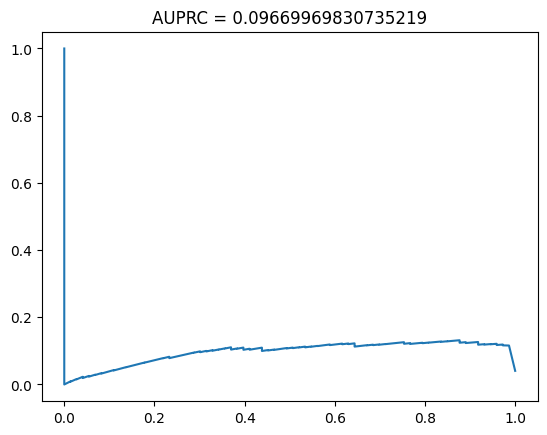

In [32]:
prc_df = auprc(adata_label_uncertainty, return_curve=True)
plt.plot(prc_df.Recall, prc_df.Precision);
plt.title(f'AUPRC = {prc_df["AUPRC"][0]}');